Using device: cuda
Average Loss       : 0.5222
Global Accuracy    : 0.8721
Macro Precision    : 0.4099
Macro Recall       : 0.3544
Macro F1-score     : 0.3516

CNN Model: /storage/courses/CropIdentification/DSWProject_CropIdentification/models/best_model_cnn.pth
Test Loss: 0.5222
Accuracy: 0.8721
Precision: N/A
Recall: N/A
F1-score: N/A


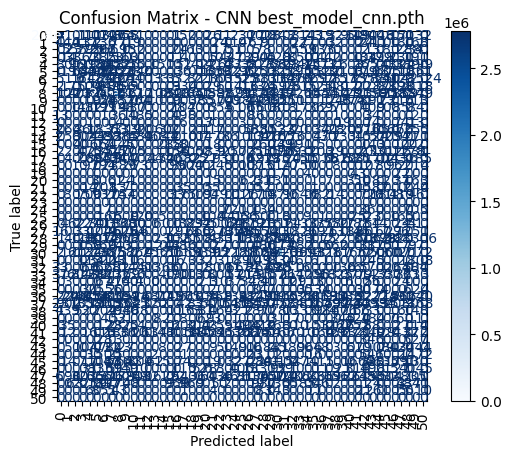

/storage/courses/CropIdentification/DSWProject_CropIdentification/venv/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [13:23:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/storage/courses/CropIdentification/DSWProject_CropIdentification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/storage/cours


Random Forest Model: /storage/courses/CropIdentification/DSWProject_CropIdentification/models/xgb_best_model.joblib
Test Accuracy: 0.6379
Precision: 0.6435
Recall: 0.6379
F1-score: 0.6390


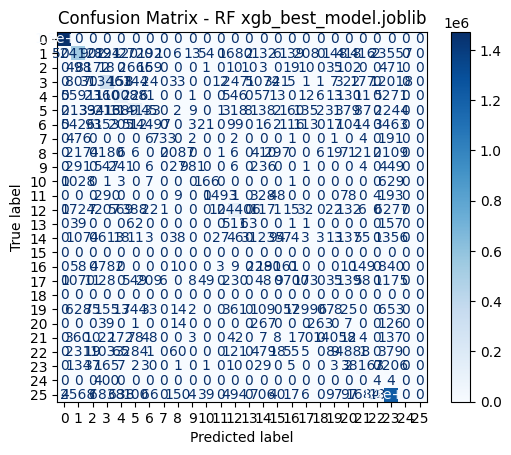

In [7]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import h5py
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from CNN.CNN_Model import CropTypeClassifier
from eval import evaluate

# Set device to GPU if available for CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ----------- CNN Evaluation ------------

# Load CNN test dataset from HDF5
with h5py.File('/storage/courses/CropIdentification/DSWProject_CropIdentification/data/dataset_test.h5', 'r') as f:
    X_test_cnn = torch.tensor(f['data'][:])
    Y_test_cnn = torch.tensor(f['labels'][:]).long()

test_dataset_cnn = TensorDataset(X_test_cnn, Y_test_cnn)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

def evaluate_cnn_model(model_path, kernel_size=5, num_classes=51):
    """
    Load CNN model, evaluate on test set, print metrics and plot confusion matrix.
    """
    model = CropTypeClassifier(num_classes=num_classes, kernel_size=kernel_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    criterion = nn.CrossEntropyLoss(ignore_index=255)

    y_true = []
    y_pred = []
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in test_loader_cnn:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

            preds = outputs.argmax(dim=1)
            y_true.append(y.view(-1).cpu())
            y_pred.append(preds.view(-1).cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    avg_loss = total_loss / total_samples

    _, metrics = evaluate(
        y_true=y_true,
        y_pred=y_pred,
        num_classes=num_classes,
        total_loss=total_loss,
        data_length=total_samples,
        plot_cm=False
    )

    print(f"\nCNN Model: {model_path}")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics.get('precision', 'N/A')}")
    print(f"Recall: {metrics.get('recall', 'N/A')}")
    print(f"F1-score: {metrics.get('f1_score', 'N/A')}")

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation=90)
    plt.title(f"Confusion Matrix - CNN {os.path.basename(model_path)}")
    plt.show()

# ----------- Random Forest Evaluation ------------

def evaluate_rf_model(model_path, data_path='/storage/courses/CropIdentification/DSWProject_CropIdentification/data/test_pixelwise.npz',
                        scaler_path='/storage/courses/CropIdentification/DSWProject_CropIdentification/models/scaler.joblib'):
    """
    Load Random Forest model and pixel-wise test data,
    predict on test set, print metrics, and plot confusion matrix.
    """
    data = np.load(data_path)
    X_test_rf = data['X']
    y_test_rf = data['y']

    rf_model = joblib.load(model_path)
    if scaler_path is not None:
        scaler = joblib.load(scaler_path)
        X_test_rf = scaler.transform(X_test_rf)
    y_pred_rf = rf_model.predict(X_test_rf)

    accuracy = accuracy_score(y_test_rf, y_pred_rf)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_rf, y_pred_rf, average='weighted')

    print(f"\nRandom Forest Model: {model_path}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    cm = confusion_matrix(y_test_rf, y_pred_rf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - RF {os.path.basename(model_path)}")
    plt.show()

# ----------- Main evaluation -----------

# Specify your best CNN and RF model paths here
best_cnn_models = [
    '/storage/courses/CropIdentification/DSWProject_CropIdentification/models/best_model_cnn.pth'
]

best_rf_models = [
    '/storage/courses/CropIdentification/DSWProject_CropIdentification/models/xgb_best_model.joblib'
]

# Evaluate CNN models
for cnn_path in best_cnn_models:
    evaluate_cnn_model(cnn_path, kernel_size=5, num_classes=51)

# Evaluate RF models
for rf_path in best_rf_models:
    evaluate_rf_model(rf_path)
